# The Pipeline

1. Question and required data
2. Acquire the data
3. Data Analysis
4. Prepare the data for the ML model
5. Building & Training the model
6. Testing the model
7. Interpreting the model

# Problem Introduction: Autistic Spectrum Disorder (ASD) predictive model

### Question and the required data

Waiting times for an ASD diagnosis and the lengthy procedures related to it are most surely not cost effective. 
This means that a time-effective and accurate ASD screening is imminent to help health professionals but also individuals in their diagnosis. 

Current datasets in the field are largely limited. The following is a comprehensive dataset containing 20 features. Half of them are behavioral features (AQ-10-Adult) and the other half are individual characteristics that have proved to be effective in detecting ASD. <br>
The dataset can be easily accessed at [this](https://archive.ics.uci.edu/ml/datasets/Autism+Screening+Adult) link. The original format was *arff* with the data types also not being correct. A first preprocessing of the data was therefore already done in the script *arff_to_csv.py*.

### ML problem chracteristics
1. Task: **Classification**
2. Attribute Types: **Categorical, continuous & binary**
3. Missing Values: **Yes**
4. **20 Attributes**
5. **704 Instances**
6. ML Model: **Deep Learning**
7. Deep Learning library: **Keras (Tensorflow)**
8. Hyperparameter tunning: **Talos**


#### The feature vector
- *A1_Score - A10Score:* 10 behavioral features. The answer code to the question based on the screening method used. A screening method is basically a simple measurement providing a *'yes/no'* response.
- *age:* Age in years
- *gender:* male or female
- *ethnicity:* a list of common ethnicities
- *jaundice:* whether the person was born with jaundice
- *autism:* whether any immediate family member has autism
- *country_of_res:* a list of countries of residence
- *result:* the final score based on the score algorithm of the screening method used
- *relation:* who is completing the test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense
import talos

sns.set()
tf.__version__

Using TensorFlow backend.


'2.0.0'

## Data Analysis
1. [Tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) Data: by default
2. **Acquaintance with the data**
3. Missing Data
4. Outliers
5. Class-Imbalance Problem
6. One-Hot Encoding
7. Feature Correlation

In [2]:
data = pd.read_csv('data/autism_adult.csv')
print('The dataset has {} samples and {} features (including the label)'.format(*data.shape))
data.head(3)

The dataset has 704 samples and 21 features (including the label)


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES


### Outliers

It appears that we have an odd value of 383 *@age* which we can drop right away

Moreover one sample seems to have an enthnicity of *'others'* where the convention seems to be with a starting upper case letter, *'Others'*. Let's fix that too.

In [3]:
data.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,702.000000,704.000000
mean,0.721591,0.453125,0.457386,0.495739,0.498580,0.284091,0.417614,0.649148,0.323864,0.573864,29.698006,4.875000
std,0.448535,0.498152,0.498535,0.500337,0.500353,0.451301,0.493516,0.477576,0.468281,0.494866,16.507465,2.501493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,3.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,27.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,383.000000,10.000000


In [4]:
data = data.drop(index=data[data['age'] == 383].index, axis=0)

ind = data[data['ethnicity'] == 'others'].index[0]
data.at[ind, 'ethnicity'] = 'Others'

### Acquaintance with the data

In [5]:
# The columns
data.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

### Visualise a subset of the feature vector

The columns *age_desc* & *used_app_before* seem to be useless since they only take one value. Therefore we can drop them.

In addition, 27 countries in the column *contry_of_res* appear only once. This feature should be further processed as when we perform one-hot encoding the number of features would explode.

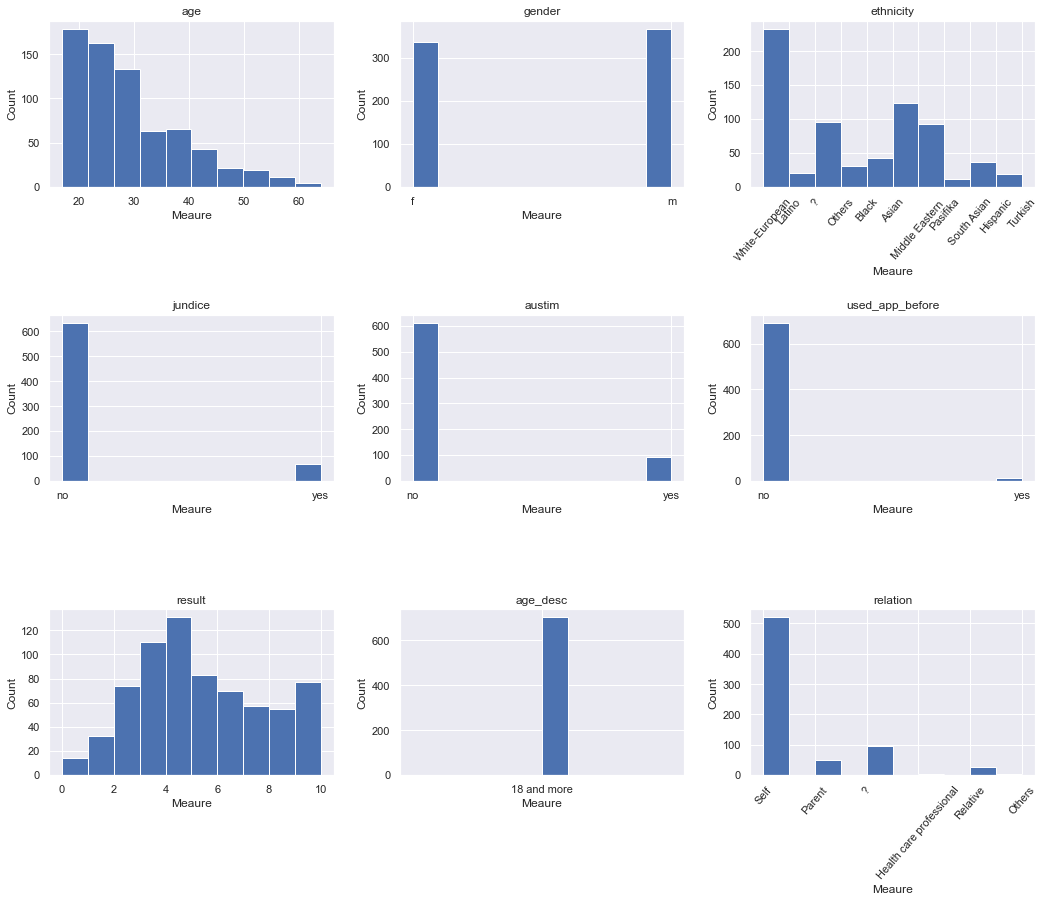

In [6]:
plt.figure(figsize=(15,13))
selected_feat = data.drop(columns=['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'Class/ASD', 'contry_of_res'], axis=1)

for i in range(1, selected_feat.shape[1]+1):
    plt.subplot(3,3,i)
    figure = plt.gca()
    figure.set_title(selected_feat.columns[i-1])
    
    bins = np.size(selected_feat.iloc[:, i-1].unique())
    plt.hist(selected_feat.iloc[:,i-1])
    if selected_feat.columns[i-1] in ['ethnicity', 'relation']:
        plt.xticks(rotation=49)
    plt.xlabel("Meaure")
    plt.ylabel("Count")
    
plt.tight_layout(pad=2)

**Fix minor issues**

In [7]:
# Rename some misspelled columns
data = data.rename(columns={'austim': 'autism', 'jundice':'jaundice', 'contry_of_res': 'country_of_res'})

# Drop useless features
data.drop(['used_app_before', 'age_desc', 'relation', 'country_of_res'], axis=1, inplace=True)

# For ethnicity, the values Turkish, Pasifika, Hispanic & Latino account for 7% of the data taken together
# We will stash these values with the column "Others" in order to reduce the number of features after 
# one-hot encoding
to_stash = ['Turkish', 'Pasifika', 'Hispanic', 'Latino']
for att in to_stash:
    
    indices = data[data['ethnicity'] == att].index
    for i in indices:
        data.at[i, 'ethnicity'] = 'Others'

### Missing Data

First of all, as we noticed earlier our dataset has missing values in the *ethnicity* attribute (denoted by *?*). This is the case for about 95 records.

Additionally we can see that our dataset has two other missing values.

Moreover, we perform a check in case the missing value are simply holding the value *0*. There seems to be none

In [8]:
print('Does our dataset contain missing values?', data.isnull().any().any())
print('How many missing values are there?', data.isna().sum().sum(), '\n')

print('Number of potentially missing values for each attribute:')
print((data[data.columns[1:6]] == 0).sum()); print()

print('Number of missing values for ethnicity:')
print(len(data[data['ethnicity'] == '?']))

Does our dataset contain missing values? True
How many missing values are there? 2 

Number of potentially missing values for each attribute:
A2_Score    384
A3_Score    381
A4_Score    354
A5_Score    352
A6_Score    503
dtype: int64

Number of missing values for ethnicity:
95


Lets investigate this more closely. It looks like we are currently missing 2 values for the **age** attribute.

In [9]:
print(data.isna().any()[lambda val: val == True])

age    True
dtype: bool


The easiest approach would be to just remove those records and since we only have two we could do that.

But lets replace them. We are going to replace them with the mean value of the *age* attribute.

In [10]:
data.fillna(data.mean(), inplace = True)

We can replace the missing ethnicities by assigning them to the most frequent ethnicity

In [11]:
data['ethnicity'].value_counts()

White-European     233
Asian              123
?                   95
Middle Eastern      92
Others              81
Black               43
South Asian         36
Name: ethnicity, dtype: int64

In [12]:
imputer = SimpleImputer(missing_values='?', strategy='most_frequent')
transformed_data = pd.DataFrame(imputer.fit_transform(data.values))
transformed_data.columns = data.columns
transformed_data.index = data.index.values
data = transformed_data

**Convert the dataframe columns to suitable data types**

In [13]:
data['jaundice'].replace(('yes', 'no'), (1, 0), inplace=True)
data['autism'].replace(('yes', 'no'), (1,0), inplace=True)
data['Class/ASD'].replace(('YES', 'NO'), (1,0), inplace=True)

In [14]:
data = data.astype({'A1_Score':int, 'A2_Score':int, 'A3_Score':int, 'A4_Score':int, 'A5_Score':int, 
                    'A6_Score':int, 'A7_Score':int, 'A8_Score':int, 'A9_Score':int, 'A10_Score':int,
                    'age': float, 'jaundice': int, 'autism': int, 'Class/ASD':int, 'result': float})

### Class Imbalance-Problem

It seems like we have a class imbalance problem.

0    0.731152
1    0.268848
Name: Class/ASD, dtype: float64


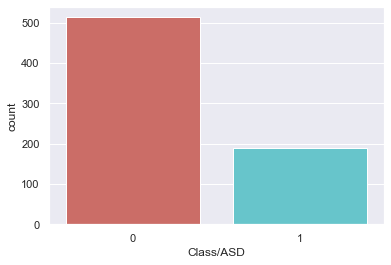

In [15]:
print(data['Class/ASD'].value_counts() / data.shape[0])

sns.countplot(x='Class/ASD', data=data, palette='hls'); plt.show()

**Are the classes well separated?**

If we have separated classes, then the class-imbalance problem is no longer a problem. Although there are tools and techniques to check this we can just simply visualize a couple of attributes for this purpose.

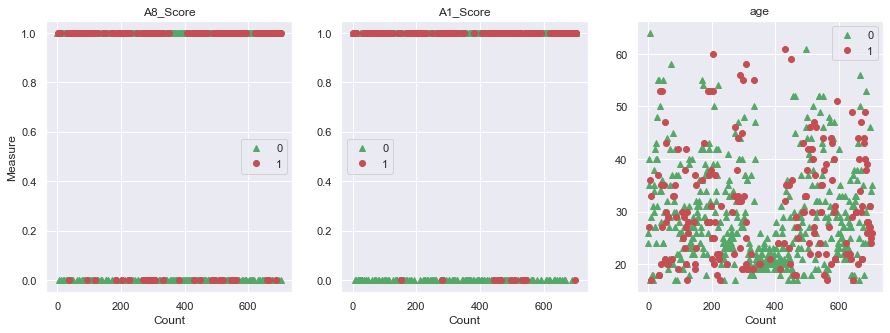

In [16]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

att1, att2, att3 = np.random.choice(data.columns.delete(16), 3, replace=False)

# Feature: residual sugar
att1_data = list(data[att1].groupby(data['Class/ASD']))

ax1.plot(att1_data[0][1], 'g^', label=att1_data[0][0])
ax1.plot(att1_data[1][1], 'ro', label=att1_data[1][0])
ax1.set_xlabel("Count"); ax1.set_ylabel("Measure"); ax1.set_title(att1_data[0][1].name)
ax1.legend()

att2_data = list(data[att2].groupby(data['Class/ASD']))
ax2.plot(att2_data[0][1], 'g^', label=att2_data[0][0])
ax2.plot(att2_data[1][1], 'ro', label=att2_data[1][0])
ax2.set_xlabel("Count"); ax2.set_ylabel(""); ax2.set_title(att2_data[0][1].name)
ax2.legend()

att3_data = list(data[att3].groupby(data['Class/ASD']))
ax3.plot(att3_data[0][1], 'g^', label=att3_data[0][0])
ax3.plot(att3_data[1][1], 'ro', label=att3_data[1][0])
ax3.set_xlabel("Count"); ax3.set_ylabel(""); ax3.set_title(att3_data[0][1].name)
ax3.legend(); plt.show()

The conclusion is that **the classes are not well-separated**.

There are techniques to fight this problem but in this case we are just going to continue like this.

### One-Hot encoding

Most ML algorithms do not work so well with categorical attributes. Here we convert them to numerical.

In [17]:
data = pd.get_dummies(data)
print('Number of features after one-hot encoding:',len(data.columns)-1)
data.head(3)

Number of features after one-hot encoding: 22


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,result,Class/ASD,gender_f,gender_m,ethnicity_Asian,ethnicity_Black,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_South Asian,ethnicity_White-European
0,1,1,1,1,0,0,1,1,0,0,...,6.0,0,1,0,0,0,0,0,0,1
1,1,1,0,1,0,0,0,1,0,1,...,5.0,0,0,1,0,0,0,1,0,0
2,1,1,0,1,1,0,1,1,1,1,...,8.0,1,0,1,0,0,0,1,0,0


### Feature Correlation

Usually we want the features to be independent of each-other. Most ML algorithms assume this by default including Neural Nets.

#### Correlation of features with the class label

Such a correlation gives us a first impression into which variable is the more important for predicting our class label

The behavioral features obtained by screening methods seem to be pretty important and the final combination of them, the result is the most important with a correlation higher than 0.8. The rest of the features seem to be weakly correlated with the class label.

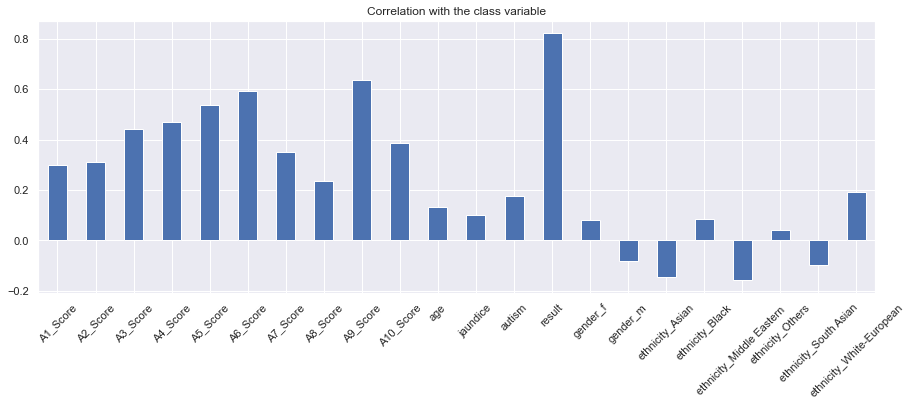

In [18]:
data.drop("Class/ASD", axis=1).corrwith(data['Class/ASD']).plot.bar(figsize=(15,5), 
                                                title='Correlation with the class variable', rot=45, fontsize=11)
plt.show()

We can also check the influence of the attributes on the class by aggregating the mean values after grouping by the class label.

The below results seem to confirm the correlation plot above. Now we have a little bit more confidence in the plot.

In [19]:
class_group = data.groupby('Class/ASD')
print(class_group.agg(np.mean))

           A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  \
Class/ASD                                                               
0          0.640078  0.359922  0.324903  0.354086  0.336576  0.122568   
1          0.941799  0.708995  0.820106  0.883598  0.941799  0.724868   

           A7_Score  A8_Score  A9_Score  A10_Score  ...    autism    result  \
Class/ASD                                           ...                       
0          0.313230  0.581712  0.143969   0.459144  ...  0.093385  3.636187   
1          0.703704  0.835979  0.814815   0.888889  ...  0.227513  8.264550   

           gender_f  gender_m  ethnicity_Asian  ethnicity_Black  \
Class/ASD                                                         
0          0.453307  0.546693         0.208171         0.048638   
1          0.544974  0.455026         0.084656         0.095238   

           ethnicity_Middle Eastern   ethnicity_Others  ethnicity_South Asian  \
Class/ASD                               

#### Correlation of features with each-other

We can nicely represent this using a heatmap

In [20]:
data.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'jaundice',
       'autism', 'result', 'Class/ASD', 'gender_f', 'gender_m',
       'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Middle Eastern ',
       'ethnicity_Others', 'ethnicity_South Asian',
       'ethnicity_White-European'],
      dtype='object')

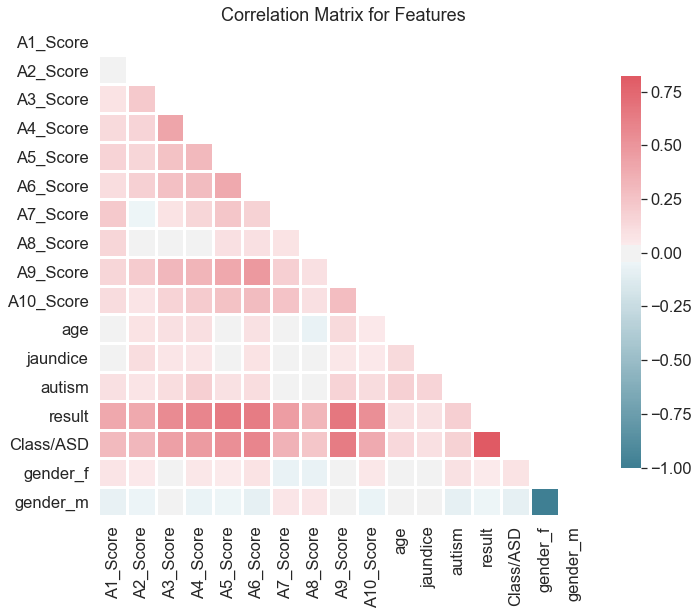

In [21]:
sns.set(style='white', font_scale=1.5)

# An array where the main diagonal separates two identical triangles
corr_matrix = data.drop(['ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Middle Eastern ',
                        'ethnicity_Others', 'ethnicity_South Asian', 'ethnicity_White-European'],axis=1).corr()

# Create a mask for the upper triangle so that we can ignore it later on when building the map
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colormap for the different values of the correlation matrix
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(12,9))
plt.title('Correlation Matrix for Features')

sns.heatmap(corr_matrix, square=True, mask=mask, cmap=cmap, center=0, linewidths=2.0, cbar_kws={'shrink':0.8})
plt.show()

Nothing to worry about. These results also confirm the conclusions that we've drawn so far

With this last plot we conclude the data analysis phase.

## Prepare the data for the Deep Learning Model

1. Class and Features Separation
2. Tran/Test Split
3. Scaling/Standardization if needed

### Class/Feature split

In [22]:
labels = data.pop('Class/ASD')
features = data
print('Shape of features', features.shape)
print('Shape of labels', labels.shape)
features.head(3)

Shape of features (703, 22)
Shape of labels (703,)


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,autism,result,gender_f,gender_m,ethnicity_Asian,ethnicity_Black,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_South Asian,ethnicity_White-European
0,1,1,1,1,0,0,1,1,0,0,...,0,6.0,1,0,0,0,0,0,0,1
1,1,1,0,1,0,0,0,1,0,1,...,1,5.0,0,1,0,0,0,1,0,0
2,1,1,0,1,1,0,1,1,1,1,...,1,8.0,0,1,0,0,0,1,0,0


### Train/Test split

Later when we do hyperparameter tuning, we shall follow another strategy but let us just split a test size of 20% for now. We also stratify the split since the classes are not balanced.

In [23]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2,
                                                                                random_state=1, stratify=labels)
print('Shape of training set', train_features.shape)
print('Shape of testing set', test_features.shape)

Shape of training set (562, 22)
Shape of testing set (141, 22)


### Feature Scaling

While feature scaling is important for a Neural Network, in our case most of our attributes are binary. With the exception of *result* and *age* they all take binary values. Therefore we shall scale only these two features.

In [24]:
scaler = StandardScaler()
to_scale = ['result', 'age']

# Scale training data
train_features_scaled = pd.DataFrame(scaler.fit_transform(train_features[to_scale]))
train_features_scaled.columns = train_features[to_scale].columns
train_features_scaled.index = train_features[to_scale].index.values
forest_train = train_features.copy()
train_features[to_scale] = train_features_scaled

# Scale testing data
test_features_scaled = pd.DataFrame(scaler.fit_transform(test_features[to_scale]))
test_features_scaled.columns = test_features[to_scale].columns
test_features_scaled.index = test_features[to_scale].index.values
forest_test = test_features.copy()
test_features[to_scale] = test_features_scaled

## Building and Training the model

We shall build a first go to the Deep Neural Network model. On the next chapter we shall see how to tune the parameters using *talos*.


### Build the Deep Neural Net

We can instantiate different aspects of the neural net either by passing a string identifier (and in this case the default parameters for the optimizer can be used) or by building an object from the class. The latter should be the used way as it gives us the possibility to do more tweaks.

[Docs](https://keras.io/api/layers/core_layers/dense/) on the dense layers

[Docs](https://keras.io/api/models/model_training_apis/) for the compile method

[Docs](https://keras.io/api/optimizers/) on optimizers

[Docs](https://keras.io/api/losses/) on the loss function
- *from_logits=True*: will significantly boost testing accuracy at a cost of training
- *label_smoothing=1*: can be played with in the range of [0,1]
- *reduction*: different options include, 'sum', keras.losses.Reduction.NONE, 

In [25]:
ann = Sequential()
ann.add(Dense(units=32, activation='relu', use_bias=True))
ann.add(Dense(units=32, activation='relu', use_bias=True))
ann.add(Dense(units=32, activation='relu', use_bias=True))
ann.add(Dense(units=1, activation='sigmoid', use_bias=False))

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
loss = keras.losses.BinaryCrossentropy(name='binary_crossentropy', from_logits=False,
                                        label_smoothing=0.05, reduction='auto')

ann.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

**Shuffle and batch the dataset**

[Docs](https://keras.io/api/models/model_training_apis/) on the fit method

1. *class_weight*: can be useful to tell the model to "pay more attention" to samples from an under-represented class

In [26]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return {cls: float(majority/count) for cls, count in counter.items()}

In [27]:
ann.fit(x=train_features.values, y=train_labels.values, epochs=100, verbose=2, shuffle=False, 
                            use_multiprocessing=True)

Epoch 1/100
 - 0s - loss: 0.6171 - accuracy: 0.7509
Epoch 2/100
 - 0s - loss: 0.4923 - accuracy: 0.8416
Epoch 3/100
 - 0s - loss: 0.3403 - accuracy: 0.9324
Epoch 4/100
 - 0s - loss: 0.2295 - accuracy: 0.9698
Epoch 5/100
 - 0s - loss: 0.1883 - accuracy: 0.9822
Epoch 6/100
 - 0s - loss: 0.1744 - accuracy: 0.9875
Epoch 7/100
 - 0s - loss: 0.1659 - accuracy: 0.9875
Epoch 8/100
 - 0s - loss: 0.1594 - accuracy: 0.9911
Epoch 9/100
 - 0s - loss: 0.1543 - accuracy: 0.9929
Epoch 10/100
 - 0s - loss: 0.1501 - accuracy: 0.9964
Epoch 11/100
 - 0s - loss: 0.1465 - accuracy: 1.0000
Epoch 12/100
 - 0s - loss: 0.1436 - accuracy: 1.0000
Epoch 13/100
 - 0s - loss: 0.1411 - accuracy: 1.0000
Epoch 14/100
 - 0s - loss: 0.1392 - accuracy: 1.0000
Epoch 15/100
 - 0s - loss: 0.1375 - accuracy: 1.0000
Epoch 16/100
 - 0s - loss: 0.1360 - accuracy: 1.0000
Epoch 17/100
 - 0s - loss: 0.1347 - accuracy: 1.0000
Epoch 18/100
 - 0s - loss: 0.1334 - accuracy: 1.0000
Epoch 19/100
 - 0s - loss: 0.1323 - accuracy: 1.0000
Ep

## Test the model

In [28]:
predictions = ann.predict(test_features)
predictions = (predictions>0.5)

print(round(100*accuracy_score(test_labels, predictions), 2))

99.29


## Interpreting the model

This model performed so good (which I wasn't expecting) so that we don't even need to perform hyperparameter tunning.

Our model classifies whether a person will have autism or not with a 99% accuracy.